# Introduction
In my previous notebook `2. Text Processing` I tokenized and stemmed the bodies and subjects of 6041 emails from the Spamassassin corpus. 

Eventually I will represent emails as one-hot vectors, with every vector representing a word in the vocabulary. Currently this would lead to a 98401-dimensional space.

In this notebook I will implement Principal Component Analysis, PCA, and use it for dimensionality reduction on my data. 

# Implementing PCA
I will start of by implementing PCA using numpy.

In [93]:
import pandas as pd
import numpy as np
import scipy

In [2]:
# Implementation using numpys single value decomposition
class PCA_svd():
    def transform(self, X, dims):
        X = X - X.mean(axis=0)
        _, _, V = np.linalg.svd(X - X.mean(axis=0))
        V_dims = V[:dims]
        return X.dot(V_dims.T)
        

In [123]:
# Implementations using correlation matrix
class PCA():
    def fit(self, X):
        self._mean = X.mean(axis=0)
        X = X - self._mean
        X_cov = np.cov(X.T)
        #eig_vals, eig_vecs = np.linalg.eig(X_cov)
        # The covariance matrix i symetric, we can exploit this structure and use scipy.linalg.eigh.
        # This is both faster, and makes sure we do not reutrn complex values.
        eig_vals, eig_vecs = scipy.linalg.eigh(X_cov)
        sort_index = eig_vals.argsort()[::-1]
        self.eig_vecs = eig_vecs[:,sort_index]
        eig_vals = eig_vals[sort_index]
        self.information = eig_vals/eig_vals.sum()
        
    def transform(self, X, dim=None):
        X = X - self._mean
        if not dim:
            dim = len(self.eig_vecs)
        
        # If dim is set to a ratio, then find out how many dimensions are required to keep that ratio of information
        if 0 <= dim < 1:
            dim = np.argmax(np.cumsum(self.information) > dim)+1
        return X.dot(self.eig_vecs[:,:dim])
        
        
        

Let's test out or implementation by comparing with the the svd implementation and sklearns PCA implementation.

In [102]:
X = np.array([[1, 2], [1,3], [1,5]])

In [103]:
X

array([[1, 2],
       [1, 3],
       [1, 5]])

In [104]:
X.mean(axis=0)

array([ 1.        ,  3.33333333])

In [105]:
from sklearn.decomposition import PCA as sklearnPCA

In [106]:
pca = PCA()

In [107]:
sk_pca = sklearnPCA()

In [108]:
sk_pca.fit_transform(X)

array([[-1.33333333,  0.        ],
       [-0.33333333, -0.        ],
       [ 1.66666667,  0.        ]])

In [109]:
pca.fit(X)

In [110]:
pca.transform(X, 2)

array([[-1.33333333,  0.        ],
       [-0.33333333,  0.        ],
       [ 1.66666667,  0.        ]])

In [111]:
pca_svd = PCA_svd()

In [112]:
pca_svd.transform(X, 2)

array([[-1.33333333,  0.        ],
       [-0.33333333,  0.        ],
       [ 1.66666667,  0.        ]])

Equivalent results for our toy matrix. 

Let's test on a random vector.

In [113]:
from numpy.random import rand

In [114]:
Y = rand(5, 5)

In [115]:
pca.fit(Y)

In [116]:
sk_pca.fit(Y)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [117]:
np.cumsum(pca.information)

array([ 0.54371944,  0.79931928,  0.97368967,  1.        ,  1.        ])

In [118]:
np.cumsum(sk_pca.explained_variance_ratio_)

array([ 0.54371944,  0.79931928,  0.97368967,  1.        ,  1.        ])

In [119]:
Y_pca = pca.transform(Y)
Y_pca

array([[  6.81315770e-01,  -3.49414383e-03,   1.82281574e-01,
          6.94261164e-02,   1.14011675e-16],
       [  8.63931448e-02,  -3.40252047e-01,  -3.61998669e-01,
         -1.56769895e-02,   3.92384778e-18],
       [ -5.50913011e-02,   5.12094916e-01,  -1.80132096e-01,
         -1.61229465e-02,   4.38146170e-17],
       [ -1.26430764e-01,  -8.41658770e-02,   2.35120422e-01,
         -1.49842344e-01,  -2.31191702e-16],
       [ -5.86186850e-01,  -8.41828486e-02,   1.24728769e-01,
          1.12216164e-01,   1.61784362e-16]])

In [120]:
Y_sk_pca = sk_pca.transform(Y)
Y_sk_pca

array([[  6.81315770e-01,  -3.49414383e-03,  -1.82281574e-01,
         -6.94261164e-02,  -1.16015621e-17],
       [  8.63931448e-02,  -3.40252047e-01,   3.61998669e-01,
          1.56769895e-02,   7.70229439e-18],
       [ -5.50913011e-02,   5.12094916e-01,   1.80132096e-01,
          1.61229465e-02,   4.90948860e-18],
       [ -1.26430764e-01,  -8.41658770e-02,  -2.35120422e-01,
          1.49842344e-01,   2.57755221e-17],
       [ -5.86186850e-01,  -8.41828486e-02,  -1.24728769e-01,
         -1.12216164e-01,   7.68327592e-17]])

Some dimensions have opposite directions, but this does not matter. All I need is for the principal components to be parallel!

Let's do a quick benchmark as well.

In [121]:
X = rand(1000, 1000)

print("My implementation:")
%time pca.fit(X)

print("sklearn's implementation:")
%time sk_pca.fit(X)

My implementation:
Wall time: 528 ms
sklearn's implementation:
Wall time: 873 ms


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [122]:
X = rand(10000, 1000)

print("My implementation:")
%time pca.fit(X)

print("sklearn's implementation:")
%time sk_pca.fit(X)

My implementation:
Wall time: 1.13 s
sklearn's implementation:
Wall time: 4.07 s


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In these cases my implementation performed better. I won't dive into why this is, or check if this is always the case. It's just good to see that it's not hopelessly ineffective.

Now let's move on with the project, time to do some dimensionality reduction on the email data!

# Encode the email data as one hot word vectors

In [25]:
data = pd.read_csv('stemmed_data.csv', encoding='latin').drop('Unnamed: 0', axis=1)

In [26]:
data.head()

,dataset,subject,body
0,spam,"['life', 'insur', '-', 'whi', 'pay', 'more', '?']","['replacement_tag', 'replacement_tag', 'replac..."
1,spam,"['[', 'ilug', ']', 'guarante', 'to', 'lose', '...","['1', ')', 'fight', 'the', 'risk', 'of', 'canc..."
2,spam,"['guarante', 'to', 'lose', '10-12', 'lb', 'in'...","['1', ')', 'fight', 'the', 'risk', 'of', 'canc..."
3,spam,"['Re', ':', 'Fw', ':', 'user', 'name', '&', 'p...","['#', '#', '#', '#', '#', '#', '#', '#', '#', ..."
4,spam,"['[', 'ilug-soci', ']', 're', ':', 'guarante',...","['I', 'thought', 'you', 'might', 'like', 'thes..."


All vectors have been saved as strings, I'll need to parse them. (I should probably have chosen a better form of storage)

In [27]:
data.shape

(6041, 3)

In [28]:
import re

In [29]:
def string_to_vector(s):
    # First capture group is a ' or ", second capture group lazily matches all characters up until the next occurance of
    # capture group 1. 
    pattern = r"([\"'])(.*?)\1"
    return [match[1] for match in re.findall(pattern, s)]

In [30]:
data.loc[:, ['subject', 'body']] = data.loc[:, ['subject', 'body']].applymap(string_to_vector)

## Reduce the number of initial dimensions
Ideally I would just run PCA on the whole data set, with each unique word represented as it's own dimension. 

This is not feasible with my machine though, as I would have to calculate almost 100,000 principal components. From laborations with benchmarking my PCA above, I know I cannot handle a 1,000 x 10,000 matrix. In this case I have 6,041 rows, so the dimensions will definitely have to be smaller than 10,000.

I know from  `2. Text Processing` that over 65,000 words occur in only one email. Words like this will not be very usefull in classification, so let's see if we can reduce the number of dimensions by dropping words with to few occurences.

In [31]:
stemmed_dictionary = {}
for i, row in data.iterrows():
    # Only count 1 occurance per mail
    for word in set(row['body'] + row['subject']):
        try:
            stemmed_dictionary[word] +=1
        except KeyError:
            stemmed_dictionary[word] = 1
stemmed_dictionary_df = pd.DataFrame.from_dict(data=stemmed_dictionary, orient='index').reset_index().rename(columns={0 : 'occurrences', 'index' : 'word'})

In [32]:
stemmed_dictionary_df = stemmed_dictionary_df.sort_values('occurrences', ascending=False)

In [33]:
print("Unique words: {}".format(stemmed_dictionary_df['word'].nunique()))

Unique words: 98401


Let's visualise how many words occur in x or more emails.

In [34]:
len(stemmed_dictionary_df[stemmed_dictionary_df['occurrences'] > 2])

19571

In [35]:
y = np.array([len(stemmed_dictionary_df[stemmed_dictionary_df['occurrences'] > i]) for i in range(0, len(data))])

In [36]:
x = np.arange(len(data))

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

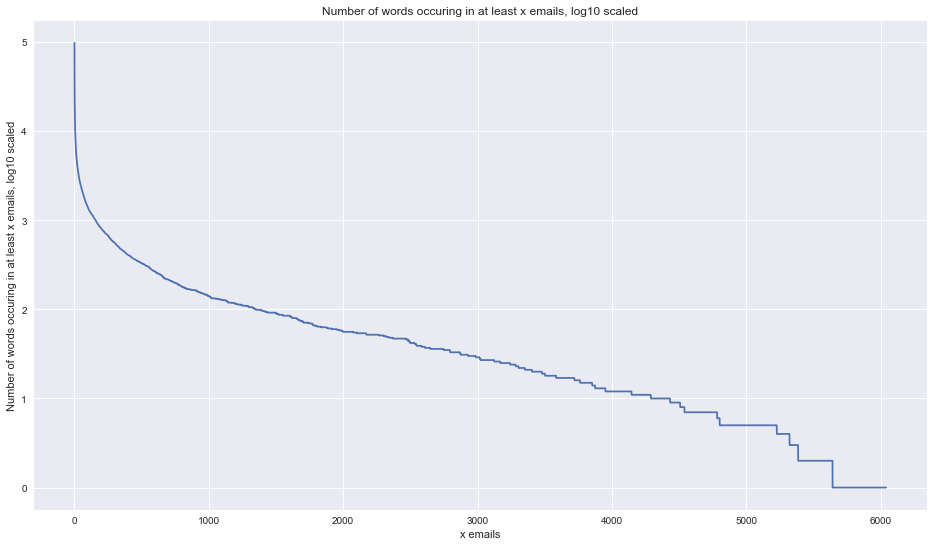

In [124]:
f, ax = plt.subplots(figsize=(16,9))
plt.plot(x, np.log10(y, where = (y!=0)))
ax.set_ylabel('Number of words occuring in at least x emails, log10 scaled')
ax.set_xlabel('x emails')
ax.set_title('Number of words occuring in at least x emails, log10 scaled')

A little bit over 100 words occur in more than 1000 documents. I want to keep much more data than that though. Let's have a more detailed look at what happends if I set a cut off close to 0.

In [139]:
for i in range(0, 20, 1):
    print("{} unique words with a cut off at {} occurences".format(y[i], i+1))

98401 unique words with a cut off at 1 occurences
32639 unique words with a cut off at 2 occurences
19571 unique words with a cut off at 3 occurences
14877 unique words with a cut off at 4 occurences
12063 unique words with a cut off at 5 occurences
10476 unique words with a cut off at 6 occurences
9311 unique words with a cut off at 7 occurences
8398 unique words with a cut off at 8 occurences
7686 unique words with a cut off at 9 occurences
7109 unique words with a cut off at 10 occurences
6604 unique words with a cut off at 11 occurences
6188 unique words with a cut off at 12 occurences
5860 unique words with a cut off at 13 occurences
5586 unique words with a cut off at 14 occurences
5328 unique words with a cut off at 15 occurences
5101 unique words with a cut off at 16 occurences
4905 unique words with a cut off at 17 occurences
4714 unique words with a cut off at 18 occurences
4536 unique words with a cut off at 19 occurences
4375 unique words with a cut off at 20 occurences


I probably need to set the cutoff around 20... This feels really sketchy though. A word that occurs in 20 emails out of 6,000 might very well be a tell if the email is spam or ham. 

Maybe the PCA approach is no good with my limited hardware. I throw away a lot of information in order to allow each remaining word to have impact. Anyway, let's keep going and see what results I get.

NOTE: After some experimentation, I ended up needing to set the cutoff around 60 (~1,500 unique words) to run my implementation of PCA. This felt like way to large of a cutoff. I want to reduce the number of dimensions without losing to much information by using PCA. If I throw away most of my data before applying PCA I almost render PCA pointless.

I neded up optimising my implementation by using [scipy.linalg.eigh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigh.html#scipy.linalg.eigh) function which takes advatange of the symetry of he covariance matrix. Now I am able to set the cutoff much lower. I chose 10 as it allows me to do PCA in under 2 minutes.

## Map each unique word to a dimension


In [140]:
stemmed_dictionary_df.index = np.arange(len(stemmed_dictionary_df))

In [127]:
words = stemmed_dictionary_df[stemmed_dictionary_df['occurrences'] >= 10]['word']

In [128]:
len(words)

7109

In [129]:
word_vec_map = dict(zip(words, np.arange(len(words))))

Any word not among the 7,109 words we have chosen will have no effect in classification. This could potentially be a big drawback, but is a consequence of the way we encode the emails. If a word cannot be observed during training, I cannot use it during classification either.

## Encode all emails

I realise by now that I should have set aside a test set much earlier. I have introduced a bias by selecting top 7,109 words among all emails and not just a training set. Oh well.

In [130]:
# Encodes an email as a one hot matrix. Make no difference of subject and body.
def encode_email(email):
    encoding = np.zeros(len(word_vec_map))
    for word in set(email['body'] + email['subject']):
        if word in word_vec_map:
            #print(word_vec_map[word])
            encoding[word_vec_map[word]] = 1
    return list(encoding)

In [131]:
encoded_emails = data.apply(encode_email, axis=1)

In [132]:
encoded_emails = np.array([np.array(email) for email in encoded_emails])

# Dimensionality reduction on the email word vectors

In [133]:
pca = PCA()

In [134]:
encoded_emails.shape

(6041, 7109)

In [135]:
%time pca.fit(encoded_emails)

Wall time: 1min 31s


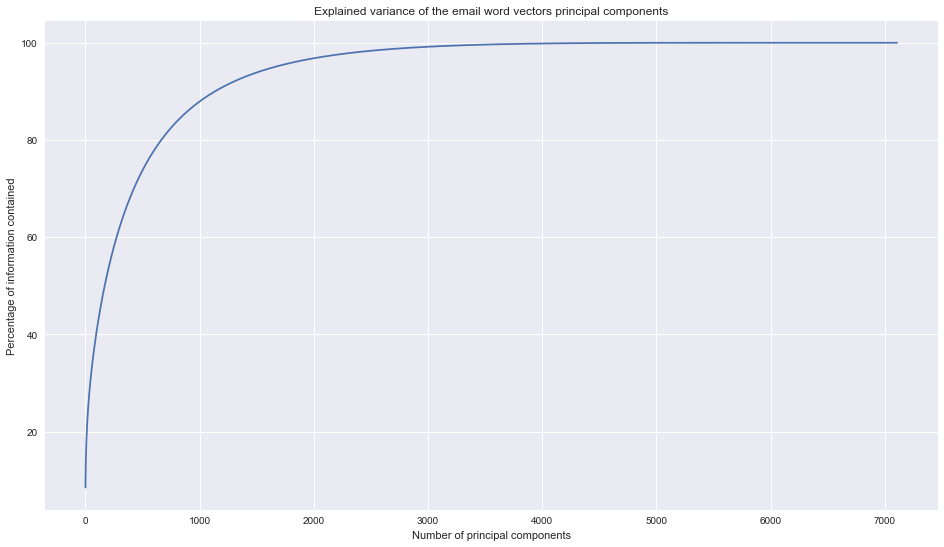

In [145]:
f, ax = plt.subplots(figsize=(16,9))
plt.plot(np.cumsum(pca.information) * 100)
ax.set_ylabel('Percentage of information contained')
ax.set_xlabel('Number of principal components')
ax.set_title('Explained variance of the email word vectors principal components')